In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter
import nltk
from nltk.util import ngrams


#  **Import**

In [2]:
!pip install transformers torch pandas

In [3]:
!pip install sacrebleu


In [4]:
!pip install rouge_score

In [5]:
!pip install sentencepiece

In [6]:
!pip install transformers[sentencepiece]

In [7]:
!transformers-cli cache clear

2024-07-01 14:52:47.337458: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-01 14:52:47.337515: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-01 14:52:47.339005: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
usage: transformers-cli <command> [<args>]
Transformers CLI tool: error: argument {convert,download,env,run,serve,login,whoami,logout,repo,add-new-model-like,lfs-enable-largefiles,lfs-multipart-upload,pt-to-tf}: invalid choice: 'cache' (choose from 'convert', 'download', 'env', 'run', 'serve', 'login', 'whoami', 'logout', 'repo', 'add-new-model-like', 'lfs-enable

In [8]:
!pip install transformers[torch]

In [9]:
!pip install accelerate -U


In [10]:
import accelerate


print("Accelerate version:", accelerate.__version__)

Accelerate version: 0.31.0


In [11]:
!pip install transformers[torch] -U

In [12]:
!pip install --upgrade pip

In [13]:
!pip install git+https://github.com/csebuetnlp/normalizer

  Cloning https://github.com/csebuetnlp/normalizer to /tmp/pip-req-build-xwfsyq4m
  Running command git clone --filter=blob:none --quiet https://github.com/csebuetnlp/normalizer /tmp/pip-req-build-xwfsyq4m
  Resolved https://github.com/csebuetnlp/normalizer to commit d405944dde5ceeacb7c2fd3245ae2a9dea5f35c9
  Preparing metadata (setup.py) ... done


In [14]:
!pip install transformers==4.10.3

  Using cached transformers-4.10.3-py3-none-any.whl.metadata (51 kB)
  Using cached sacremoses-0.1.1-py3-none-any.whl.metadata (8.3 kB)
  Using cached tokenizers-0.10.3.tar.gz (212 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
Using cached transformers-4.10.3-py3-none-any.whl (2.8 MB)
Using cached sacremoses-0.1.1-py3-none-any.whl (897 kB)
  error: subprocess-exited-with-error
  
  × Building wheel for tokenizers (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> [51 lines of output]
      running bdist_wheel
      running build
      running build_py
      creating build
      creating build/lib.linux-x86_64-cpython-310
      creating build/lib.linux-x86_64-cpython-310/tokenizers
      copying py_src/tokenizers/__init__.py -> build/lib.linux-x86_64-cpython-310/tokenizers
      creating build/lib.linux-x86_64-cpython-310/tokenizers/models
      copying py_src/tokenizers/models/__

In [15]:
!pip install torch transformers

In [16]:
# !pip install accelerate==0.20.3

In [17]:
import torch
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer, DataCollatorForSeq2Seq, Trainer, TrainingArguments
from normalizer import normalize
import pandas as pd
import numpy as np
import nltk
from nltk.translate.bleu_score import corpus_bleu
from sacrebleu import sentence_bleu
from rouge_score import rouge_scorer
from sklearn.model_selection import train_test_split
import os


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

2024-07-01 14:53:45.589283: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-01 14:53:45.589343: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-01 14:53:45.590862: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [18]:
# train_data = pd.read_csv("/content/noakhali_Translation_Main_Train_Dataset.csv")
# test_data = pd.read_csv("/content/noakhali_Translation_Main_test_Dataset.csv")
# validation_data = pd.read_csv("/content/noakhali_Main_Validation_Dataset.csv")
train_data = pd.read_csv("/kaggle/input/newnoakhali-dataset5k/NewTrain_dataset.csv")
test_data = pd.read_csv("/kaggle/input/newnoakhali-dataset5k/NewTest_Dataset.csv")
validation_data = pd.read_csv("/kaggle/input/newnoakhali-dataset5k/NewValid_Dataset.csv")

In [19]:
train_data.head(5)

,Noakhali_text,Formal_text
0,অন মাছ আর সবজি দি ভাত খাইতে খরচ হয়,এখন মাছ আর সবজি দিয়ে ভাত খেতে খরচ হয়
1,"হয়তাল্লিশ টিয়া, দুইহাজার বিশ সালে মোরগ দি ভাত ...","পয়তাল্লিশ টাকা, দুইহাজার বিশ সালে মোরগ দিয়ে ভা..."
2,"অন মাোরগ দি ভাত খাইতে খরচ হয় পঞ্ছাশ টিয়া,","এখন মাোরগ দিয়ে ভাত খেতে খরচ হয় পঞ্ছাশ টাকা,"
3,দুইহাজার বিশ সালে গরু মাংস খরচ হইত পয়ত্রিশ তুন...,দুইহাজার বিশ সালে গরু মাংস খরচ হত পয়ত্রিশ থেকে...
4,অন গরুর মাংস দি ভাত খাইতে খরচ হয় ষাইট তুন সত্ত...,এখন গরুর মাংস দিয়ে ভাত খেতে খরচ হয় ষাট থেকে সত...


In [20]:
# Rename the columns to match the expected format
train_data.rename(columns={'Noakhali_text': 'input_text', 'Formal_text': 'labels'}, inplace=True)
train_data.head()

,input_text,labels
0,অন মাছ আর সবজি দি ভাত খাইতে খরচ হয়,এখন মাছ আর সবজি দিয়ে ভাত খেতে খরচ হয়
1,"হয়তাল্লিশ টিয়া, দুইহাজার বিশ সালে মোরগ দি ভাত ...","পয়তাল্লিশ টাকা, দুইহাজার বিশ সালে মোরগ দিয়ে ভা..."
2,"অন মাোরগ দি ভাত খাইতে খরচ হয় পঞ্ছাশ টিয়া,","এখন মাোরগ দিয়ে ভাত খেতে খরচ হয় পঞ্ছাশ টাকা,"
3,দুইহাজার বিশ সালে গরু মাংস খরচ হইত পয়ত্রিশ তুন...,দুইহাজার বিশ সালে গরু মাংস খরচ হত পয়ত্রিশ থেকে...
4,অন গরুর মাংস দি ভাত খাইতে খরচ হয় ষাইট তুন সত্ত...,এখন গরুর মাংস দিয়ে ভাত খেতে খরচ হয় ষাট থেকে সত...


In [21]:
test_data.head()

,Noakhali_text,Formal_text
0,আরে এক গেলাস হানি দে,আমাকে এক গ্লাস পানি দাও
1,এক্কানা গরি ভালোবাসা দিত ন পাইত্তো লাইগগোদে না,আমাকে একটুও কি ভালোবাসতে পার না?
2,আরে দুগা হাকি দেএ না,আমাকে দুইটা পাখি দেও না
3,আরে বাইচত্তি দিলি না তুই ও বাঁইচতি পারবি না,আমাকে বাঁচতে দিলা না তুই ও বাঁচতে পারবি না
4,আরে শরম দিয়েন্না,আমাকে লজ্জা দিবেন না


In [22]:
# Rename the columns to match the expected format
test_data.rename(columns={'Noakhali_text': 'input_text', 'Formal_text'	: 'labels'}, inplace=True)
test_data.head()

,input_text,labels
0,আরে এক গেলাস হানি দে,আমাকে এক গ্লাস পানি দাও
1,এক্কানা গরি ভালোবাসা দিত ন পাইত্তো লাইগগোদে না,আমাকে একটুও কি ভালোবাসতে পার না?
2,আরে দুগা হাকি দেএ না,আমাকে দুইটা পাখি দেও না
3,আরে বাইচত্তি দিলি না তুই ও বাঁইচতি পারবি না,আমাকে বাঁচতে দিলা না তুই ও বাঁচতে পারবি না
4,আরে শরম দিয়েন্না,আমাকে লজ্জা দিবেন না


In [23]:
validation_data.head()

,Noakhali_text,Formal_text
0,বড় মাইয়া ভালা ইকগা থ্রিপিসের লাই স্কুলে যায় না,বড় মেয়ে ভালো একটা থ্রিপিসের জন্য স্কুলে যায় না
1,বরি দিয়ে মাছ ধর,বড়শি দিয়ে মাছ ধর
2,বাজারত যাই কি কি আনিভি,বাজারে গিয়ে কি কি আনবা
3,বাজারত যাই কি কি আনিবেন,বাজারে গিয়ে কি কি আনবেন
4,"বাজারত যা, কিছু বাজারসাজার গরি আই","বাজারে যাও, কিছু বাজার করে নিয়ে আস"


In [24]:
# Rename the columns to match the expected format
validation_data.rename(columns={'Noakhali_text': 'input_text', 'Formal_text'	: 'labels'}, inplace=True)
validation_data.head()

,input_text,labels
0,বড় মাইয়া ভালা ইকগা থ্রিপিসের লাই স্কুলে যায় না,বড় মেয়ে ভালো একটা থ্রিপিসের জন্য স্কুলে যায় না
1,বরি দিয়ে মাছ ধর,বড়শি দিয়ে মাছ ধর
2,বাজারত যাই কি কি আনিভি,বাজারে গিয়ে কি কি আনবা
3,বাজারত যাই কি কি আনিবেন,বাজারে গিয়ে কি কি আনবেন
4,"বাজারত যা, কিছু বাজারসাজার গরি আই","বাজারে যাও, কিছু বাজার করে নিয়ে আস"


In [25]:
model_name = "csebuetnlp/banglat5"
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=False)

config.json:   0%|          | 0.00/659 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/990M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


tokenizer_config.json:   0%|          | 0.00/1.83k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/1.11M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/1.79k [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


In [26]:
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer


In [27]:
from torch.utils.data import Dataset, DataLoader

In [28]:
class Seq2SeqDataset(Dataset):
    def __init__(self, data, tokenizer, max_length=128):
        """
        Args:
            data: A DataFrame containing 'input_text' and 'labels' columns.
            tokenizer: A Hugging Face tokenizer.
            max_length: Maximum sequence length.
        """
        self.input_text = data['input_text'].apply(normalize).tolist()
        self.labels = data['labels'].apply(normalize).tolist()
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.input_text)

    def __getitem__(self, idx):
        input_text = self.input_text[idx]
        label_text = self.labels[idx]

        # Tokenize the input text
        input_encodings = self.tokenizer(
            input_text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )

        # Tokenize the label text to get its 'input_ids' and 'attention_mask'
        label_encodings = self.tokenizer(
            label_text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )

        return {
            'input_ids': input_encodings['input_ids'].squeeze(),
            'attention_mask': input_encodings['attention_mask'].squeeze(),
            'labels': label_encodings['input_ids'].squeeze(),
        }


In [29]:
# Create train , test and validation datasets
train_dataset = Seq2SeqDataset(train_data, tokenizer)
test_dataset = Seq2SeqDataset(test_data, tokenizer)
validation_dataset = Seq2SeqDataset(validation_data, tokenizer)

# Create train , test and validation dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)  #batch_size=32
test_dataloader = DataLoader(test_dataset, batch_size=16) #batch_size=32
validation_dataloader = DataLoader(validation_dataset, batch_size=16) #batch_size=32


# **For training dataset**

In [30]:
# Assuming you have already created the train_dataloader
for data_point in train_dataloader:
    input_ids = data_point['input_ids']
    attention_mask = data_point['attention_mask']
    labels = data_point['labels']
''' print("Input IDs:", input_ids)
    print("Attention Mask:", attention_mask)
    print("Labels:", labels)
'''

' print("Input IDs:", input_ids)\n    print("Attention Mask:", attention_mask)\n    print("Labels:", labels)\n'

# **For test dataset**

In [31]:
# Assuming you have already created the test_dataloader
for data_point in test_dataloader:
    input_ids = data_point['input_ids']
    attention_mask = data_point['attention_mask']
    labels = data_point['labels']
''' print("Input IDs:", input_ids)
    print("Attention Mask:", attention_mask)
    print("Labels:", labels)
'''

' print("Input IDs:", input_ids)\n    print("Attention Mask:", attention_mask)\n    print("Labels:", labels)\n'

# **For validation dataset**

In [32]:
# Assuming you have already created the validation_dataloader
for data_point in validation_dataloader:
    input_ids = data_point['input_ids']
    attention_mask = data_point['attention_mask']
    labels = data_point['labels']
'''    print("Input IDs:", input_ids)
    print("Attention Mask:", attention_mask)
    print("Labels:", labels)'''

'    print("Input IDs:", input_ids)\n    print("Attention Mask:", attention_mask)\n    print("Labels:", labels)'

# **from training dataset , I have done only one example decoding**

In [33]:
# Assuming you have already created the train_dataloader with shuffle
for data_point in train_dataloader:
    input_ids = data_point['input_ids'][0]  # Assuming you want the first example
    attention_mask = data_point['attention_mask'][0]
    labels = data_point['labels'][0]

    # Decode input_ids and labels
    input_text = tokenizer.decode(input_ids, skip_special_tokens=True)
    output_text = tokenizer.decode(labels, skip_special_tokens=True)

    print("Input Text:", input_text)
    print("Output Text:", output_text)

    # Exit the loop after processing the first example
    break


Input Text: মানুষের বিবেকবুদ্ধি কতটা খারাপ অইতে হারে
Output Text: মানুষের বিবেকবুদ্ধি কতটা খারাপ হতে পারে


# **from testing dataset , I have done only one example decoding**

In [34]:
# Assuming you have already created the test_dataloader
for data_point in test_dataloader:
    input_ids = data_point['input_ids'][0]  # Assuming you want the first example
    attention_mask = data_point['attention_mask'][0]
    labels = data_point['labels'][0]

    # Decode input_ids and labels
    input_text = tokenizer.decode(input_ids, skip_special_tokens=True)
    output_text = tokenizer.decode(labels, skip_special_tokens=True)

    print("Input Text:", input_text)
    print("Output Text:", output_text)

    # Exit the loop after processing the first example
    break


Input Text: আরে এক গেলাস হানি দে
Output Text: আমাকে এক গ্লাস পানি দাও


# **from validation dataset , I have done only one example decoding**

In [35]:
# Assuming you have already created the validation_dataloader
for data_point in validation_dataloader:
    input_ids = data_point['input_ids'][0]  # Assuming you want the first example
    attention_mask = data_point['attention_mask'][0]
    labels = data_point['labels'][0]

    # Decode input_ids and labels
    input_text = tokenizer.decode(input_ids, skip_special_tokens=True)
    output_text = tokenizer.decode(labels, skip_special_tokens=True)

    print("Input Text:", input_text)
    print("Output Text:", output_text)

    # Exit the loop after processing the first example
    break


Input Text: বড় মাইয়া ভালা ইকগা থ্রিপিসের লাই স্কুলে যায় না
Output Text: বড় মেয়ে ভালো একটা থ্রিপিসের জন্য স্কুলে যায় না


In [36]:
# Move the model to the device (CPU or GPU)
model.to(device)


T5ForConditionalGeneration(
  (shared): Embedding(32128, 768)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 768)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=768, out_features=768, bias=False)
              (k): Linear(in_features=768, out_features=768, bias=False)
              (v): Linear(in_features=768, out_features=768, bias=False)
              (o): Linear(in_features=768, out_features=768, bias=False)
              (relative_attention_bias): Embedding(32, 12)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseGatedActDense(
              (wi_0): Linear(in_features=768, out_features=2048, bias=False)
              (wi_1): Linear(in_features=768, out_features=2048, bias=False)
              (wo):

In [37]:
import accelerate
import transformers

print("Accelerate version:", accelerate.__version__)
print("Transformers version:", transformers.__version__)

Accelerate version: 0.31.0
Transformers version: 4.42.3


In [38]:
from transformers import TrainingArguments
from transformers import AdamW

from torch.optim import AdamW

# Create a custom optimizer using torch.optim.AdamW
custom_optimizer = AdamW(
    model.parameters(),
    lr=1e-3,  # Learning rate
    eps=1e-8,  # Epsilon value to prevent division by zero
    weight_decay=0.01,  # Weight decay (L2 regularization)
)

#if you have 1,000 training examples and a batch size of 100, you would have 10 iterations in each epoch (1,000 / 100 = 10)
'''
This parameter determines how many small batches are accumulated before performing a weight update.
In your code, it's set to 8, which means you'll accumulate gradients over 8 small batches before performing a weight update.
This effectively simulates a larger batch size without requiring more GPU memory.
So, you are updating the model's weights less frequently compared to the number of actual batches processed.
'''



'''
Learning rate determines how quickly the model learns from the data.
The learning rate scheduler type is set to "cosine_with_restarts," which is a type of learning rate schedule.
 Warmup steps are the number of initial training steps with a smaller learning rate, and weight decay introduces L2 regularization to the optimizer.
'''



'''
Number of Iterations per Epoch = Number of Training Samples / Batch Size
Total Iterations = Number of Iterations per Epoch * Number of Epochs
'''
# Define the TrainingArguments
training_args = TrainingArguments(
    output_dir='/kaggle/working/',
    num_train_epochs=25,
    per_device_train_batch_size=6,
    gradient_accumulation_steps=8,  # Accumulate gradients over 8 small batches
    evaluation_strategy="steps",
    eval_steps=100,
    save_total_limit=2,
    save_steps=100,
    learning_rate=1e-3,
    do_train=True,
    do_eval=True,
    remove_unused_columns=False,
    push_to_hub=False,
    report_to="none",
    load_best_model_at_end=True,
    lr_scheduler_type="cosine_with_restarts",  # Set the learning rate scheduler type
    warmup_steps=100,  # Number of warmup steps
    weight_decay=0.01,  # Weight decay (L2 regularization)
    logging_dir='/kaggle/working/',  # Use the same directory for logs
    logging_steps=100,  # Log every 500 steps
)


/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [39]:
from transformers import DataCollatorForSeq2Seq

# Create a data collator for sequence-to-sequence tasks
data_collator = DataCollatorForSeq2Seq(
    tokenizer=tokenizer,  # Your Hugging Face tokenizer
    model=model,
    padding=True,
    max_length=128,
    label_pad_token_id=tokenizer.pad_token_id,
)


In [40]:

# Define the Trainer with the custom optimizer
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=train_dataset,
    eval_dataset=validation_dataset,
    optimizers=(custom_optimizer, None),  # Pass the custom optimizer here
)


# **Training start here**

In [41]:
# Fine-tune the model
trainer.train()

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2778: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/transformers/data/data_collator.py:656: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:261.)
  batch["labels"] = torch.tensor(batch["labels"], dtype=torch.int64)


Step,Training Loss,Validation Loss
100,37.440100,0.457575
200,1.065900,0.347751
300,0.462400,0.333570
400,0.450400,0.324087
500,0.438800,0.308481
600,0.622200,0.339415
700,0.397700,0.156127
800,0.225600,0.100537
900,0.112900,0.088684
1000,0.086300,0.084148


/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2778: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2778: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2778: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2778: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(
/opt

TrainOutput(global_step=2350, training_loss=1.7787319323357116, metrics={'train_runtime': 4766.2867, 'train_samples_per_second': 23.866, 'train_steps_per_second': 0.493, 'total_flos': 1.929372316257485e+16, 'train_loss': 1.7787319323357116, 'epoch': 24.76943346508564})

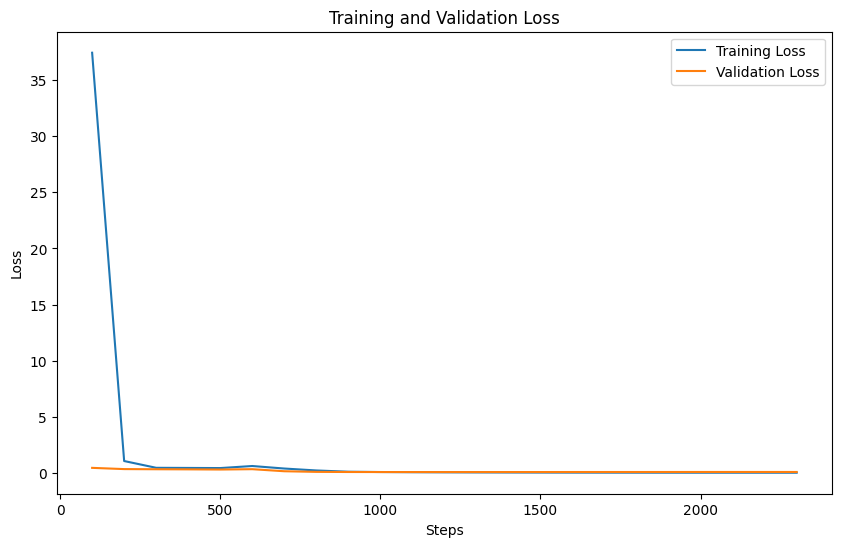

In [42]:
import os
import json
import matplotlib.pyplot as plt

# Extract the training logs
logs = trainer.state.log_history

# Separate steps and loss values
train_loss_values = []
eval_loss_values = []
train_steps = []
eval_steps = []

for log in logs:
    if 'loss' in log:
        train_loss_values.append(log['loss'])
        train_steps.append(log['step'])
    if 'eval_loss' in log:
        eval_loss_values.append(log['eval_loss'])
        eval_steps.append(log['step'])

# Plot the training and validation loss
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(train_steps, train_loss_values, label='Training Loss')
plt.plot(eval_steps, eval_loss_values, label='Validation Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


# **Saving model and tokenizer**

In [43]:
from transformers import AutoModelForSeq2SeqLM

# Save the model
model.save_pretrained("/kaggle/working/NoakhaliNewBanglat5-finetuned.pt")

# Save the tokenizer
tokenizer.save_pretrained("/kaggle/working/NoakhaliNewBanglat5-finetuned.json")


('/kaggle/working/NoakhaliBanglamt5-finetuned.json/tokenizer_config.json',
 '/kaggle/working/NoakhaliBanglamt5-finetuned.json/special_tokens_map.json',
 '/kaggle/working/NoakhaliBanglamt5-finetuned.json/spiece.model',
 '/kaggle/working/NoakhaliBanglamt5-finetuned.json/added_tokens.json')

# **Loading trained model and tokenizer**

In [44]:
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

# Load the saved model
model = AutoModelForSeq2SeqLM.from_pretrained("/kaggle/working/NoakhaliBanglamt5-finetuned.pt")

# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained("/kaggle/working/NoakhaliBanglamt5-finetuned.json")


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
You set `add_prefix_space`. The tokenizer needs to be converted from the slow tokenizers


In [45]:
!pip install datasets

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [46]:
!pip install python-Levenshtein

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.4/177.4 kB 3.2 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 45.7 MB/s eta 0:00:0000:0100:01


In [47]:
!pip install jiwer

In [48]:
!pip install rouge-score
#https://github.com/google-research/google-research/tree/master/rouge
#https://huggingface.co/spaces/evaluate-metric/rouge [Different types of ROUGE scores]

In [49]:
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.0 MB/s eta 0:00:00a 0:00:01


In [50]:
model.to(device)

T5ForConditionalGeneration(
  (shared): Embedding(32128, 768)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 768)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=768, out_features=768, bias=False)
              (k): Linear(in_features=768, out_features=768, bias=False)
              (v): Linear(in_features=768, out_features=768, bias=False)
              (o): Linear(in_features=768, out_features=768, bias=False)
              (relative_attention_bias): Embedding(32, 12)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseGatedActDense(
              (wi_0): Linear(in_features=768, out_features=2048, bias=False)
              (wi_1): Linear(in_features=768, out_features=2048, bias=False)
              (wo):

# **Loading evaluation metrics**

In [51]:
import torch
import Levenshtein
from evaluate import load
# Define the move_to_device function
def move_to_device(batch, device):
    if isinstance(batch, torch.Tensor):
        return batch.to(device)
    elif isinstance(batch, list):
        return [move_to_device(item, device) for item in batch]
    elif isinstance(batch, dict):
        return {key: move_to_device(value, device) for key, value in batch.items()}
    else:
        return batch  # If it's not a tensor, list, or dict, leave it as is

# Load the evaluation metric for Character Error Rate (CER) and Word Error Rate (WER) and Exact Match(em)
cer_metric = load("cer")
wer_metric = load("wer")
# meteor = load('meteor')
exact_match_metric = load("exact_match")

# Load BLEU and ROUGE metrics
bleu_metric = load("bleu")
rouge_metric = load('rouge')

# Initialize lists to store generated translations and references
generated_translations = []
references = []
Noakhali_text = []

# Generate translations for the test dataset
for batch in test_dataloader:
    # Move the batch to CUDA
    batch = move_to_device(batch, 'cuda')

    input_text = batch['input_ids']  # Access the input_text using the correct key
    labels = batch['labels']  # Access the labels using the correct key
    
    # Append input_text to Noakhali_text
    Noakhali_text.extend(tokenizer.batch_decode(input_text, skip_special_tokens=True))

    # Generate translations
    translation_ids = model.generate(input_text, max_length=512, num_beams=4, length_penalty=2.0, early_stopping=True)

    # Move the translation_ids to CPU to decode
    translation_ids = translation_ids.to('cpu')

    generated_translation = tokenizer.batch_decode(translation_ids, skip_special_tokens=True)

    generated_translations.extend(generated_translation)
    references.extend(tokenizer.batch_decode(labels, skip_special_tokens=True))  # Decoding the label IDs

# Make sure to move generated_translations back to CPU for evaluation if necessary
generated_translations = [translation if not isinstance(translation, str) else translation for translation in generated_translations]



In [52]:
print("Number of generated translations:", len(generated_translations))
print("Number of references:", len(references))
print("Number of input:", len(Noakhali_text))

Number of generated translations: 249
Number of references: 249
Number of input: 249


In [53]:
for i in range(len(generated_translations)):
    print(f"Noakhali Text: {Noakhali_text[i]}")
    print(f"Target Text: {references[i]}")
    print(f"Predicted Text: {generated_translations[i]}")
    print("="*50)

Noakhali Text: আরে এক গেলাস হানি দে
Target Text: আমাকে এক গ্লাস পানি দাও
Predicted Text: আমাকে এক গ্লাস পানি দাও
Noakhali Text: এক্কানা গরি ভালোবাসা দিত ন পাইত্তো লাইগগোদে না
Target Text: আমাকে একটুও কি ভালোবাসতে পার না?
Predicted Text: একটা গরী ভালবাসা দিতে না পারা লাগবে না
Noakhali Text: আরে দুগা হাকি দেএ না
Target Text: আমাকে দুইটা পাখি দেও না
Predicted Text: আমাকে দুইটা পাকে দে না
Noakhali Text: আরে বাইচত্তি দিলি না তুই ও বাঁইচতি পারবি না
Target Text: আমাকে বাঁচতে দিলা না তুই ও বাঁচতে পারবি না
Predicted Text: আমাকে বাচতে দিলে না তুই ও বাচতে পারবি না
Noakhali Text: আরে শরম দিয়েন্না
Target Text: আমাকে লজ্জা দিবেন না
Predicted Text: আমাকে শরম দিওনা
Noakhali Text: আংগো আইজগা রাইনচে গরুর গোস্ত দি বিরিয়ানি চাইলের ভাত
Target Text: আমাদের আজকে রানছে গরুর গোস্ত দিয়ে বিরিয়ানি চালের ভাত
Predicted Text: আমাদের আজকে রাতে রান্না করছে গরুর মাংস দিয়ে বিরিয়ানি রান্না করার ভাত
Noakhali Text: আঙ্গো এলাকায় বিয়া কইরবেন
Target Text: আমাদের এলাকায় বিয়ে করবেন
Predicted Text: আমাদের এলাকায় বিয়ে

In [54]:
# Calculate Character Error Rate (CER) and Word Error Rate (WER)
results_CER = cer_metric.compute(predictions=generated_translations, references=references)
results_WER = wer_metric.compute(predictions=generated_translations, references=references)

# Calculate Exact Match (EM) and METEOR(M)
results_em = exact_match_metric.compute(predictions=generated_translations, references=references)
# results_met = meteor.compute(predictions=generated_translations, references=references)

 # Calculate Bilingual Evaluation Understudy (BLEU) and Recall-Oriented Understudy for Gisting Evaluation (ROUGE)
results_bleu = bleu_metric.compute(predictions=generated_translations, references=references)
results_rouge = rouge_metric.compute(predictions=generated_translations, references=references)


# Calculate Levenshtein Distance
levenshtein_distances = [Levenshtein.distance(generated, reference) for generated, reference in zip(generated_translations, references)]


# **Printing every evaluation metrics**

In [55]:
print(results_CER)
print(results_WER)
print(results_em)
# print(results_met)
print(results_bleu)
print(results_rouge)
print(levenshtein_distances)

0.21290626471973623
0.3823163138231631
{'exact_match': 0.1285140562248996}
{'bleu': 0.41602189928121114, 'precisions': [0.67550894509562, 0.4752186588921283, 0.352626892252894, 0.2745995423340961], 'brevity_penalty': 0.9907891351190139, 'length_ratio': 0.9908312958435208, 'translation_length': 1621, 'reference_length': 1636}
{'rouge1': 0.0, 'rouge2': 0.0, 'rougeL': 0.0, 'rougeLsum': 0.0}
[0, 27, 3, 3, 9, 25, 0, 6, 18, 12, 0, 24, 8, 5, 8, 13, 9, 4, 14, 9, 17, 15, 1, 4, 0, 0, 16, 9, 7, 1, 8, 14, 1, 6, 7, 4, 2, 0, 1, 4, 2, 2, 0, 6, 7, 3, 4, 3, 7, 3, 3, 3, 1, 8, 15, 2, 2, 0, 5, 5, 19, 18, 10, 1, 1, 8, 22, 9, 6, 1, 0, 8, 7, 6, 9, 8, 6, 1, 10, 0, 5, 10, 11, 16, 6, 3, 14, 16, 6, 15, 10, 11, 7, 1, 10, 11, 11, 11, 3, 2, 3, 3, 0, 0, 5, 12, 0, 6, 8, 8, 0, 3, 0, 0, 2, 12, 6, 0, 14, 9, 3, 19, 3, 0, 5, 0, 4, 15, 6, 4, 1, 0, 1, 12, 6, 19, 6, 3, 3, 4, 8, 6, 6, 14, 8, 0, 5, 3, 1, 4, 9, 16, 0, 3, 25, 10, 0, 9, 0, 8, 4, 10, 21, 12, 19, 0, 2, 14, 1, 13, 16, 11, 11, 3, 0, 7, 13, 8, 16, 2, 10, 5, 9, 19, 4, 

In [56]:
total_correct = 0
total_samples = len(references)

for generated, reference in zip(generated_translations, references):
    levenshtein_distance = Levenshtein.distance(generated, reference)
    max_length = max(len(generated), len(reference))
    accuracy = 1 - (levenshtein_distance / max_length)
    if accuracy >= 0.8:  # Adjust the threshold as needed
        total_correct += 1

        
accuracy = total_correct / total_samples
print("Accuracy:", accuracy)


Accuracy: 0.5341365461847389


In [57]:
!zip -r file.zip /kaggle/working

  adding: kaggle/working/ (stored 0%)
  adding: kaggle/working/NoakhaliBanglamt5-finetuned.json/ (stored 0%)
  adding: kaggle/working/NoakhaliBanglamt5-finetuned.json/spiece.model (deflated 60%)
  adding: kaggle/working/NoakhaliBanglamt5-finetuned.json/tokenizer_config.json (deflated 94%)
  adding: kaggle/working/NoakhaliBanglamt5-finetuned.json/added_tokens.json (deflated 83%)
  adding: kaggle/working/NoakhaliBanglamt5-finetuned.json/special_tokens_map.json (deflated 85%)
  adding: kaggle/working/.virtual_documents/ (stored 0%)
  adding: kaggle/working/NoakhaliBanglamt5-finetuned.pt/ (stored 0%)
  adding: kaggle/working/NoakhaliBanglamt5-finetuned.pt/generation_config.json (deflated 29%)
  adding: kaggle/working/NoakhaliBanglamt5-finetuned.pt/model.safetensors (deflated 11%)
  adding: kaggle/working/NoakhaliBanglamt5-finetuned.pt/config.json (deflated 48%)
  adding: kaggle/working/checkpoint-1200/ (stored 0%)
  adding: kaggle/working/checkpoint-1200/scheduler.pt (deflated 54%)
  addin

In [58]:
!ls

NoakhaliBanglamt5-finetuned.json  checkpoint-1200  file.zip
NoakhaliBanglamt5-finetuned.pt	  checkpoint-2350


In [59]:
from IPython.display import FileLink
FileLink(r'file.zip')

/kaggle/working/file.zip